## Runtime Environment:  
Python 3.7  
Opencv_python 3.4.1  
numpy 1.20.1  
pytorch 1.10.0  
tqdm 4.62.3

<open cv mush be 3.4.1 !! If the version higher than 3.4.1, the cell will be stuck>  
<NEED A pytorch 1.10.0 and tqdm>


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import torch
from nu_net import NU_net

In [2]:
print(cv2.__version__)
print(torch.__version__)

3.4.15
1.10.0+cpu


# 0. Function definations, just RUN them.

### 0.1 Functions to show / compare image(s). Below Cell is only for drawing, you can just execute it. 

In [3]:
'''
    Usage: 
    Print image(s) using pyplot: 
        im_show(image_list, [titles], [colors_of_each_title], [#columns], [dpi])

    Print the first, the middle, the last image in a folder using pyplot:
        show_three_images(image_folder, [dpi])

    Show a image folder using CV2: 
        show_images_in_animation_cv(image_folder, [interval]=100, [repeat_delay]=1000, [window_name]='Animation')
        compare_images_in_animation_cv(image_folder_list, [interval]=100, [repeat_delay]=1000, [window_name]='Animation', [window_width]=1200)
'''

def im_show(im_array, im_titles=[], title_colors=[], cols=2, dpi=200):
    color_map = ['black', 'red', 'green', 'blue']
    image_no = len(im_array)
    rows = round(image_no / cols)
    titles = [f'image {i}' for i in range(image_no)]
    for t in range(len(im_titles)):
        titles[t] = im_titles[t]

    colors = [0 for i in range(image_no)]
    for t in range(len(title_colors)):
        colors[t] = title_colors[t]

    if image_no == 1:
        plt.figure(figsize=(6, 2), dpi=dpi)
        img = im_array[0]
        if len(img.shape)==3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
        else:
            plt.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax = plt.gca()
        ax.set_title(titles[0], {'color':color_map[colors[0]]})
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.show()
        return

    _, axes = plt.subplots(rows, cols, sharex=True, figsize=(max(6, cols * 4), rows * 4), dpi=dpi)
    axes_dim = len(np.array(axes).shape)
    if axes_dim == 1:
        for i in range(image_no):
            ax = axes[i]
            img = im_array[i]
            if len(img.shape)==3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
            else:
                ax.imshow(img, cmap="gray", vmin=0, vmax=255)
            ax.set_title(titles[i], {'color':color_map[colors[i]]})
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
    else:
        row, col = 0, 0
        for i in range(rows * cols):
            ax = axes[row][col]
            if i < image_no:
                img = im_array[i]
                if len(img.shape)==3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    ax.imshow(img)
                else:
                    ax.imshow(img, cmap="gray", vmin=0, vmax=255)
                ax.set_title(titles[i], {'color':color_map[colors[i]]})
                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)
            else:
                plt.delaxes(ax)
            col += 1
            if col == cols:
                row += 1
                col = 0

    plt.show()

def show_three_images(folder, dpi=400):
    im_show(
    [folder[0], folder[len(folder)//2], folder[-1]], 
    ['0', str(len(folder)//2-1), str(len(folder)-1)], 
    cols=3, 
    dpi=dpi
)

def frame_trackbar_onChange(pos, prop):
    prop['i'] = pos
    cv2.imshow(prop['window_name'], prop['imageSet'][pos])
    return
    
def window_onMouse(event, x, y, flag, prop):
    if event == cv2.EVENT_LBUTTONDOWN:
        prop['pause'] = not prop['pause']
    elif event == cv2.EVENT_MOUSEWHEEL and prop['pause']:
        if flag > 0:
            prop['i'] = max(prop['i'] - 1, 0)
        else:
            prop['i'] = min(prop['i'] + 1, len(prop['imageSet']) - 1)
        cv2.setTrackbarPos('frame', prop['window_name'], prop['i'])

def show_images_in_animation_cv(imageSet, interval=100, repeat_delay=1000, window_name='Animation'):
    visable = True
    prop = {'window_name': window_name, 'i': 0, 'imageSet': imageSet, 'pause': False}
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    cv2.createTrackbar('frame', window_name, 0, len(imageSet) - 1, lambda v: frame_trackbar_onChange(v, prop))
    cv2.setMouseCallback(window_name, window_onMouse, prop)
    while visable:
        while prop['pause'] and cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE):
            cv2.waitKey(1)
            
        cv2.setTrackbarPos('frame', prop['window_name'], prop['i'])
        
        key = cv2.waitKey(interval)
        visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)
        if not visable:
            break
        prop['i'] += 1
        
        if prop['i'] == len(imageSet):
            prop['i'] = 0
            cv2.waitKey(repeat_delay)
            visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)

def compare_images_in_animation_cv(imageSets, interval=100, repeat_delay=1000, window_name='Animation', window_width=1200):
    visable = True
    imageSets_in_BGR = []
    for s in imageSets:
        if len(s[0].shape) == 2:
            new_set = []
            for img in s:
                new_set.append(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
            imageSets_in_BGR.append(new_set)
        else:
            imageSets_in_BGR.append(s)

    imageSets_in_BGR = np.array(imageSets_in_BGR).transpose(1,0,2,3,4)
    height, width, _ = np.hstack(imageSets_in_BGR[0]).shape

    imageSet = []
    for imgs in imageSets_in_BGR:
        imageSet.append(np.hstack(imgs))
        
    prop = {'window_name': window_name, 'i': 0, 'imageSet': imageSet, 'pause': False}
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, window_width, int(window_width * height / width))
    cv2.createTrackbar('frame', window_name, 0, len(imageSet) - 1, lambda v: frame_trackbar_onChange(v, prop))
    cv2.setMouseCallback(window_name, window_onMouse, prop)
    while visable:
        while prop['pause'] and cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE):
            cv2.waitKey(1)
        cv2.setTrackbarPos('frame', window_name, prop['i'])
        key = cv2.waitKey(interval)
        visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)
        if not visable:
            break
        prop['i'] += 1
        if prop['i'] == len(imageSet):
            prop['i'] = 0
            cv2.waitKey(repeat_delay)
            visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)

### 0.2 Load / save image sets

In [4]:
def open_files(path='./Sequences/01/', flags=cv2.IMREAD_COLOR):
    image_list = []
    file_list = sorted([files for _, _, files in os.walk(path)][0])
    for fname in file_list:
        src = path + fname
        img = cv2.imread(src, flags)
        image_list.append(img)
    return image_list

def save_files(img_folder, path):
    os.makedirs(path, exist_ok=True)
    for i in range(len(img_folder)):
        img = img_folder[i]
        fname = str(i+1)
        while len(fname) < 3:
            fname = '0' + fname
        cv2.imwrite(path + fname + '.png', img)

### 0.3 Image processing

In [5]:
# Use the maximum and minimum value of an entire image folder to stretch images #
def global_grey_stretch(img_folder):
    global_max = np.max(img_folder)
    global_min = np.min(img_folder)
    new_img_folder = []
    for i in img_folder:
        i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        new_img_folder.append(np.uint8((i - global_min) / (global_max - global_min) * 255))
    return new_img_folder

# (Unused) Clean background noise #
def clear_background(img_folder):
    folder = []
    for img in img_folder:
        count = np.bincount(np.reshape(img, -1))
        threshold_value = np.argmax(count)
        _, img = cv2.threshold(img, threshold_value, 255, cv2.THRESH_TOZERO)
        folder.append(img)
    return folder

'''
    Image transformation. The opposite number represents the opposite operation.
    mode = 1: horizontal flip
           2: Vertical flip  
           3: Rotate 90 degrees clockwise
           4: Rotate 90 degrees counter-clockwise
           5: Rotate 180 degrees
'''
def image_processing_with_model_transform(img, mode):
    if mode == 1 or mode == -1:
        img = cv2.flip(img, 1)
    elif mode == 2 or mode == -2:
        img = cv2.flip(img, 0)
    elif mode == 3 or mode == -4:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif mode == 4 or mode == -3:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif mode == 5 or mode == -5:
        img = cv2.rotate(img, cv2.ROTATE_180)
    return img

# Fill background (the maximum connected area) to a value, process the entile folder #
def fill_background(img_folder, newVal=0):
    out = []
    for img in img_folder:
        new_img = cv2.bitwise_not(img)
        w, h = new_img.shape
        _, labels, stats, _ = cv2.connectedComponentsWithStats(new_img, connectivity=4)
        max_label = np.argsort(-(stats[:, 4]))[0]
        for y in range(h //2, h):
            for x in range(w // 2, w):
                if labels[y, x] == max_label:
                    cv2.floodFill(new_img, None, (x, y), newVal)
                    break
            else:
                continue
            break
        out.append(new_img)
    return out

### 0.4 Neural network related

In [6]:
# Use network to process an image. #
def image_processing_with_model(img, model, step=64, size=128, padding=30, trans_mode=0):
    img = cv2.resize(img, (0, 0), fx=.5, fy=.5)
    img = img / 255
    out_img = np.zeros_like(img).astype(np.uint8)
    img_list = []
    positions = []
    h, w = img.shape
    for y in range((h - size) // step + 1):
        for x in range((w - size) // step + 1):
            sub = img[y*step:y*step+size, x*step:x*step+size]
            sub = image_processing_with_model_transform(sub, trans_mode)
            img_list.append([sub])
            positions.append((x*step, y*step, -trans_mode))

        sub = img[y*step:y*step+size, w-size:w]
        sub = image_processing_with_model_transform(sub, trans_mode)
        img_list.append([sub])
        positions.append((w-size, y*step, -trans_mode))

    for x in range((w - size) // step + 1):
        sub = img[h-size:h, x*step:x*step+size]
        sub = image_processing_with_model_transform(sub, trans_mode)
        img_list.append([sub])
        positions.append((x*step, h-size, -trans_mode))

    sub = img[h-size:h, w-size:w]
    sub = image_processing_with_model_transform(sub, trans_mode)
    img_list.append([sub])
    positions.append((w-size, h-size, -trans_mode))
    
    inputs = torch.Tensor(np.array(img_list)).cpu()
    outputs = model(inputs).cpu().detach().numpy()

    for i in range(len(positions)):
        x, y, t = positions[i]
        padding_top, padding_bottom = padding, padding
        padding_left, padding_right = padding, padding
        blackb = np.zeros_like(out_img)

        if x == 0: padding_left = 0
        if y == 0: padding_top = 0
        if x == w - size: padding_right = 0
        if y == h - size: padding_bottom = 0
        
        img = np.where(outputs[i][0]>0, 255, 0).astype(np.uint8)
        img = image_processing_with_model_transform(img, t)

        # or mode #
        blackb = np.zeros_like(out_img)
        blackb[y+padding_top:y+size-padding_bottom, x+padding_left:x+size-padding_right]\
         = img[padding_top:size-padding_bottom, padding_left:size-padding_right]
        out_img = cv2.bitwise_or(out_img, blackb)
        
        # replace mode #
        # out_img[y+padding_top:y+size-padding_bottom, x+padding_left:x+size-padding_right]\
        #  = np.where(outputs[i][0]>0, 255, 0)[padding_top:size-padding_bottom, padding_left:size-padding_right]

    return cv2.resize(out_img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST)

# Same as the previous function, but this will return a series of images showing the process for demonstration. #
def image_processing_with_model_demo(img, model, demo_mode, step=64, size=128, padding=30, trans_mode=0, frames=[]):
    img = cv2.resize(img, (0, 0), fx=.5, fy=.5)
    img = img / 255
    out = frames
    out_img = np.zeros_like(img).astype(np.uint8)
    if len(frames) > 0:
        out_img = frames[-1]
    positions = []
    img_list=[]
    h, w = img.shape
    for y in range((h - size) // step + 1):
        for x in range((w - size) // step + 1):
            sub = img[y*step:y*step+size, x*step:x*step+size]
            sub = image_processing_with_model_transform(sub, trans_mode)
            img_list.append([sub])
            positions.append((x*step, y*step, -trans_mode))

        sub = img[y*step:y*step+size, w-size:w]
        sub = image_processing_with_model_transform(sub, trans_mode)
        img_list.append([sub])
        positions.append((w-size, y*step, -trans_mode))

    for x in range((w - size) // step + 1):
        sub = img[h-size:h, x*step:x*step+size]
        sub = image_processing_with_model_transform(sub, trans_mode)
        img_list.append([sub])
        positions.append((x*step, h-size, -trans_mode))

    sub = img[h-size:h, w-size:w]
    sub = image_processing_with_model_transform(sub, trans_mode)
    img_list.append([sub])
    positions.append((w-size, h-size, -trans_mode))
    
    inputs = torch.Tensor(np.array(img_list)).cpu()
    outputs = model(inputs).cpu().detach().numpy()

    for i in range(len(positions)):
        x, y, t = positions[i]
        padding_top, padding_bottom = padding, padding
        padding_left, padding_right = padding, padding

        if x == 0: padding_left = 0
        if y == 0: padding_top = 0
        if x == w - size: padding_right = 0
        if y == h - size: padding_bottom = 0
        
        img = np.where(outputs[i][0]>0, 255, 0).astype(np.uint8)
        img = image_processing_with_model_transform(img, t)

        # # demo only
        if demo_mode == 0:
            blackb = np.zeros_like(out_img)
            out_img = blackb
            out_img[y+padding_top:y+size-padding_bottom, x+padding_left:x+size-padding_right]\
            = img[padding_top:size-padding_bottom, padding_left:size-padding_right]

        # or mode
        elif demo_mode == 1:
            blackb = np.zeros_like(out_img)
            blackb[y+padding_top:y+size-padding_bottom, x+padding_left:x+size-padding_right]\
            = img[padding_top:size-padding_bottom, padding_left:size-padding_right]
            out_img = cv2.bitwise_or(out_img, blackb)
            
        # # replace mode
        # elif demo_mode == 2:
        #     out_img[y+padding_top:y+size-padding_bottom, x+padding_left:x+size-padding_right]\
        #     = img[padding_top:size-padding_bottom, padding_left:size-padding_right]

        out.append(out_img.copy())
    
    return out

# Use network to process the entire folder. #
def folder_processing_with_model(image_folder, model, step=64, size=128, padding=30, trans_list=[0]):
    out = []
    for img in tqdm(image_folder, ncols=80):
        new_img = np.zeros_like(img)
        for trans_mode in trans_list:
            new_img = cv2.bitwise_or(image_processing_with_model(img, model, step, size, padding, trans_mode), new_img)
        out.append(new_img)
    show_three_images(out)
    return out

### 0.5 Calculations

In [7]:
# Find all contours in a folder. Contour with an area less than the area_threshold will be excluded. #
def find_all_contours(folder_threshold, area_threshold=50):
    out = []
    for img in folder_threshold:
        _, contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_selected = []

        for contour in contours:
            if cv2.contourArea(contour) > area_threshold:
                contours_selected.append(contour)

        out.append(contours_selected)
    return out
 
# Find the centroid of a contour. #
def find_centroid(contour):
    centroid = cv2.moments(contour)
    X = int(centroid["m10"]/centroid["m00"])
    Y = int(centroid["m01"]/centroid["m00"])
    return np.array([X, Y])

# Calculate the euclidean distance. #
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2, ord=2)

# Check if the two contours are intersect. #
def check_contours_intersection(contour_1, contour_2):
    for pt in contour_1:
        if cv2.pointPolygonTest(contour_2, pt[0].tolist(), False) >= 0:
            return True

    for pt in contour_2:
        if cv2.pointPolygonTest(contour_1, pt[0].tolist(), False) >= 0:
            return True
    return False

# Merge two contours, and get the hull contour. #
def merge_contours(contours):
    c = contours[0]
    for i in range(1, len(contours)):
        c = np.concatenate((c,contours[i]),axis=0)
    
    return cv2.convexHull(c)

# Contour pairing (in position) #
def identify_method_centroid_distance(last_contours, new_contours, max_distance=30):
    if len(last_contours) == 0:
        return (np.ones(len(new_contours), dtype=np.int16) * -1).tolist(), 0

    out = []
    last_centroid = []
    displacement = 0
    count = 0
    for contour in last_contours:
        last_centroid.append(find_centroid(contour))

    for contour in new_contours:
        v = find_centroid(contour)
        min_distance = None
        index = -1
        for i in range(len(last_centroid)):
            d = euclidean_distance(v, last_centroid[i])
            if index == -1 or min_distance > d:
                min_distance = d
                index = i
        if min_distance < max_distance:
            out.append(index)
            displacement += min_distance
            count += 1
        else:
            # Not found, it is a new ceil
            out.append(-1)

    return out, displacement / count

# Register a new ceil in ceils_info dictionary. #
def ceil_register(ceils_info):
    i = len(ceils_info['ids'])
    ceils_info['ids'].append(i)
    ceils_info['colors'].append((np.random.randint(205,size=3) + np.ones(3, dtype=np.int) * 50).tolist())
    return i
    

In [8]:
# Ceil tracking function #
def ceil_indentify(all_contours, non_splitting_area_thres=50, distance_thres=30):
    ceils_info = {'ids':[], 'colors':[]}
    last_contours = []
    ceil_ids = []
    contour_ids = []
    all_centroids = []
    division_records = []
    average_displacement = []

    contours_index = 0
    with tqdm(total=len(all_contours), ncols=80) as pbar:
        while contours_index < len(all_contours):
            repeat = False
            d_record = []
            contours = all_contours[contours_index]
            ids, disp = identify_method_centroid_distance(last_contours, contours, distance_thres)
            average_displacement.append(disp)
            _contour_ids = ids.copy()
            for i in range(len(ids)):
                if ids[i] == -1:
                    ids[i] = ceil_register(ceils_info)

                else:
                    ids[i] = ceil_ids[-1][ids[i]]

            if contours_index > 0:

                bincount = np.bincount(np.array(_contour_ids) + 1)
                ids_with_muli_children = {}
                for i in range(len(_contour_ids)):
                    if bincount[_contour_ids[i] + 1] > 1 and _contour_ids[i] != -1:
                        if _contour_ids[i] not in ids_with_muli_children.keys():
                            ids_with_muli_children[_contour_ids[i]] = []
                        ids_with_muli_children[_contour_ids[i]].append(i)

                popped = 0
                for k, v in ids_with_muli_children.items():
                    conts = []
                    for i in v:
                        conts.append(contours[i-popped])
                    hull_contour = merge_contours(conts)
                    last_area = cv2.contourArea(cv2.convexHull(last_contours[k]))
                    new_area = cv2.contourArea(hull_contour)

                    if abs(last_area - new_area) < non_splitting_area_thres:
                        for i in v:
                            all_contours[contours_index].pop(i-popped)
                            popped += 1
                        all_contours[contours_index].append(hull_contour)
                        repeat = True
                    else:
                        d_record.append(ceil_ids[-1][k])
                        for i in v:
                            ids[i] = ceil_register(ceils_info)

            if repeat:
                continue
            
            pbar.update(1)
            contours_index += 1

            centroids = {}
            for i in range(len(ids)):
                centroids[ids[i]] = find_centroid(contours[i])

            contour_ids.append(_contour_ids)
            all_centroids.append(centroids)
            division_records.append(sorted(d_record))
            ceil_ids.append(ids.copy())
            last_contours = contours
        
    division_records.append(division_records.pop(0))
    return contour_ids, all_centroids, ceils_info, ceil_ids, division_records, average_displacement

In [9]:
# Print the result #
def draw_everything(all_contours, contour_ids, all_centroids, ceils_info, ceil_ids, division_records, average_displacement, original_folder, path_length=100, info_bar=True, id_highlight=True):
    images_folder = []
    last_max_ceil_id = -1
    for i in range(len(ceil_ids)):
        new_image = original_folder[i].copy()
        average_area = 0
        ids = np.array(ceil_ids[i])
        new_ids = sorted(ids[tuple([ids > last_max_ceil_id])])
        if len(new_ids) > 0:
                last_max_ceil_id = new_ids[-1]

        if info_bar:
            new_image = np.vstack([new_image, np.zeros_like(new_image)[:87]])
        for j in range(len(ceil_ids[i])):
            color = ceils_info['colors'][ceil_ids[i][j]]
            # centroid = find_centroid(all_contours[i][j])
            centroid = tuple(all_centroids[i][ceil_ids[i][j]])

            p = i
            k = ceil_ids[i][j]
            stack = []
            lass_centroid = []
            for s in range(path_length):
                if p == 0 or k not in all_centroids[p-1]:
                    break

                lass_centroid = tuple(all_centroids[p-1][k])
                stack.append(tuple([lass_centroid, centroid]))
                centroid = lass_centroid
                p -= 1

            while stack:
                lass_centroid, centroid = stack.pop()
                # cv2.line(new_image, lass_centroid, centroid, [0,0,0], 5)
                cv2.line(new_image, lass_centroid, centroid, color, 2)
            if len(lass_centroid):
                cv2.arrowedLine(new_image, lass_centroid, centroid, [0,0,0], 3, cv2.LINE_4, shift=0, tipLength=1)
                cv2.arrowedLine(new_image, lass_centroid, centroid, color, 1, cv2.LINE_4, shift=0, tipLength=1)

            # cv2.drawContours(new_image, all_contours[i], j, [0,0,0], 3)
        for j in range(len(all_contours[i])):
            color = ceils_info['colors'][ceil_ids[i][j]]
            average_area += cv2.contourArea(all_contours[i][j])
            cv2.drawContours(new_image, all_contours[i], j, color, 2)

        average_area = average_area / len(all_contours[i])

        for j in range(len(ceil_ids[i])):
            k = ceil_ids[i][j]
            centroid = tuple(all_centroids[i][k])
            if k in division_records[i] and id_highlight:
                cv2.putText(new_image, str(ceil_ids[i][j]),centroid,1,2,[0,0,0],5)
                cv2.putText(new_image, str(ceil_ids[i][j]),centroid,1,2,[0,255,0],2)

            elif k in new_ids and id_highlight:
                cv2.putText(new_image, str(ceil_ids[i][j]),centroid,1,1,[0,0,0],3)
                cv2.putText(new_image, str(ceil_ids[i][j]),centroid,1,1,[255,255,0],1)
                
            else:
                cv2.putText(new_image, str(ceil_ids[i][j]),centroid,1,1,[0,0,0],3)
                cv2.putText(new_image, str(ceil_ids[i][j]),centroid,1,1,[255,255,255],1)
        
        if info_bar:
            text_offset = new_image.shape[0] - 86
            cv2.putText(new_image, f'#Ceils: {len(ceil_ids[i])}',(0,16 + text_offset),1,1,[255,255,255],1) 
            cv2.putText(new_image, f'Average size: {round(average_area, 3)}',(0,32 + text_offset),1,1,[255,255,255],1) 
            cv2.putText(new_image, f'Average displacement: {round(average_displacement[i], 3)}',(0,48 + text_offset),1,1,[255,255,255],1) 
            cv2.putText(new_image,'Dividing cell(s):',(0,64 + text_offset),1,1,[255,255,255],1)
            if len(division_records[i]) > 0:
                cv2.putText(new_image, str(division_records[i])[1:-1],(130,64 + text_offset),1,1,[0,255,0],1)
            else:
                cv2.putText(new_image, 'None',(130,64 + text_offset),1,1,[0,0,255],1)

            cv2.putText(new_image,'New cell(s):',(0,80 + text_offset),1,1,[255,255,255],1)
            if len(new_ids) > 0:
                cv2.putText(new_image, str(new_ids)[1:-1],(100,80 + text_offset),1,1,[255,255,0],1)
            else:
                cv2.putText(new_image, 'None',(100,80 + text_offset),1,1,[0,0,255],1)
        images_folder.append(new_image)
    return images_folder

# 1-1 Read the sequence of images and apply the contrast stretching.

In [10]:
# Can be '01', '02', '03', and '04'.
process_folder = '04'

In [11]:
folder_original = open_files(f'./Sequences/{process_folder}/')

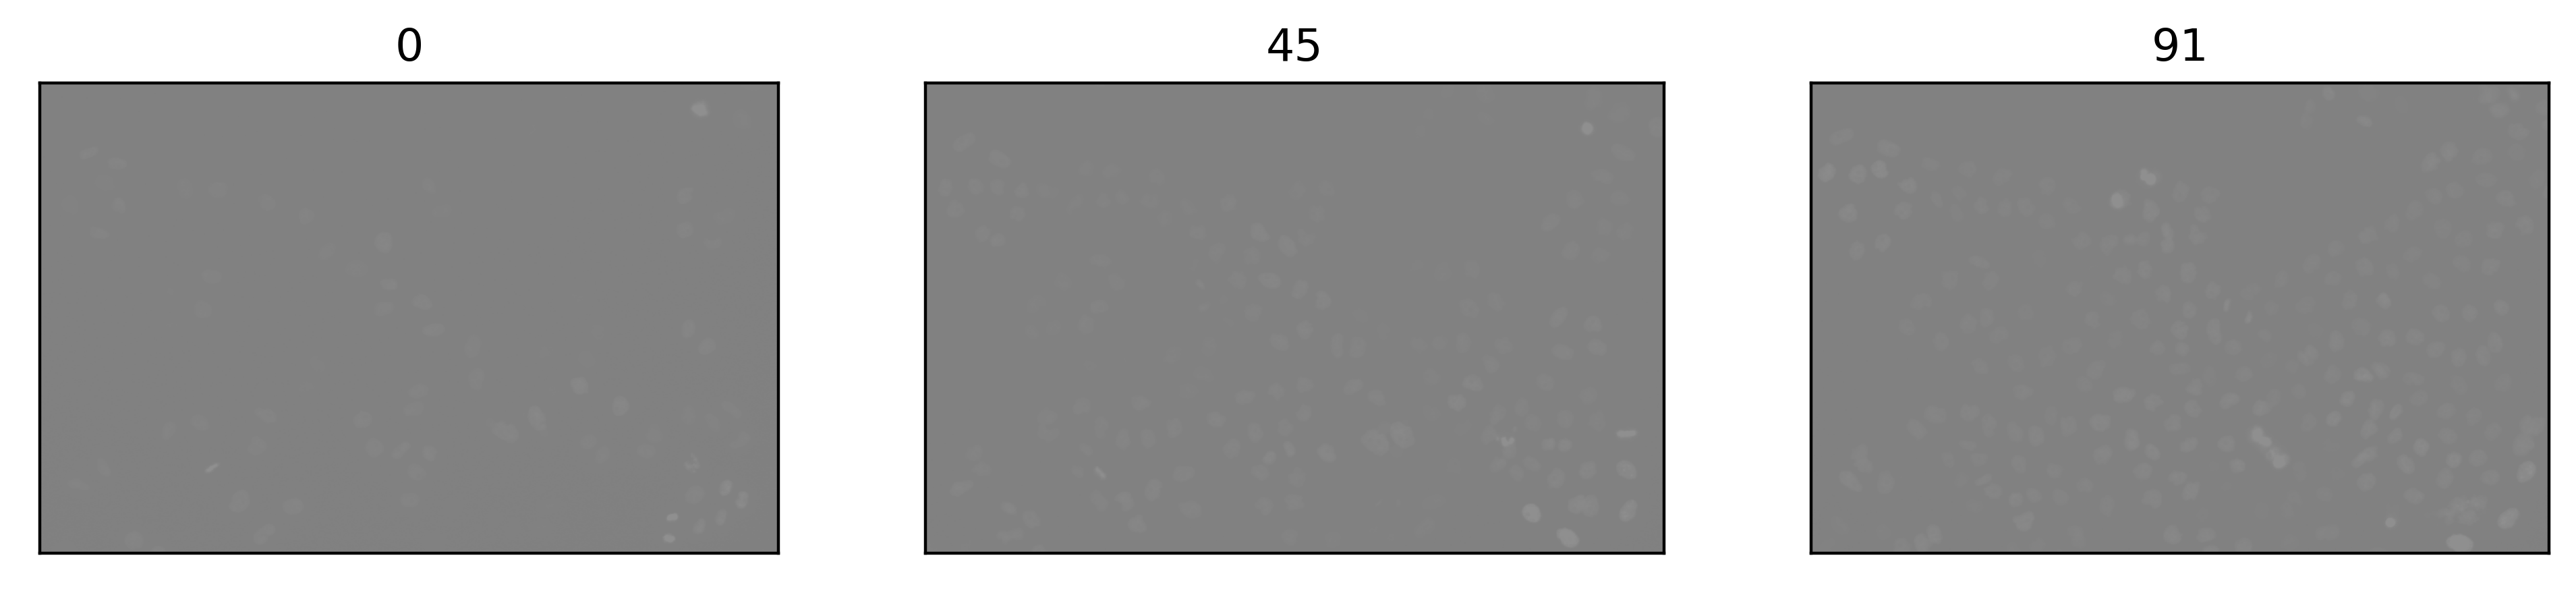

In [12]:
show_three_images(folder_original)

In [13]:
folder = global_grey_stretch(folder_original)

In [14]:
save_files(folder, f'./output_images/{process_folder}/01_grey_stretched/')

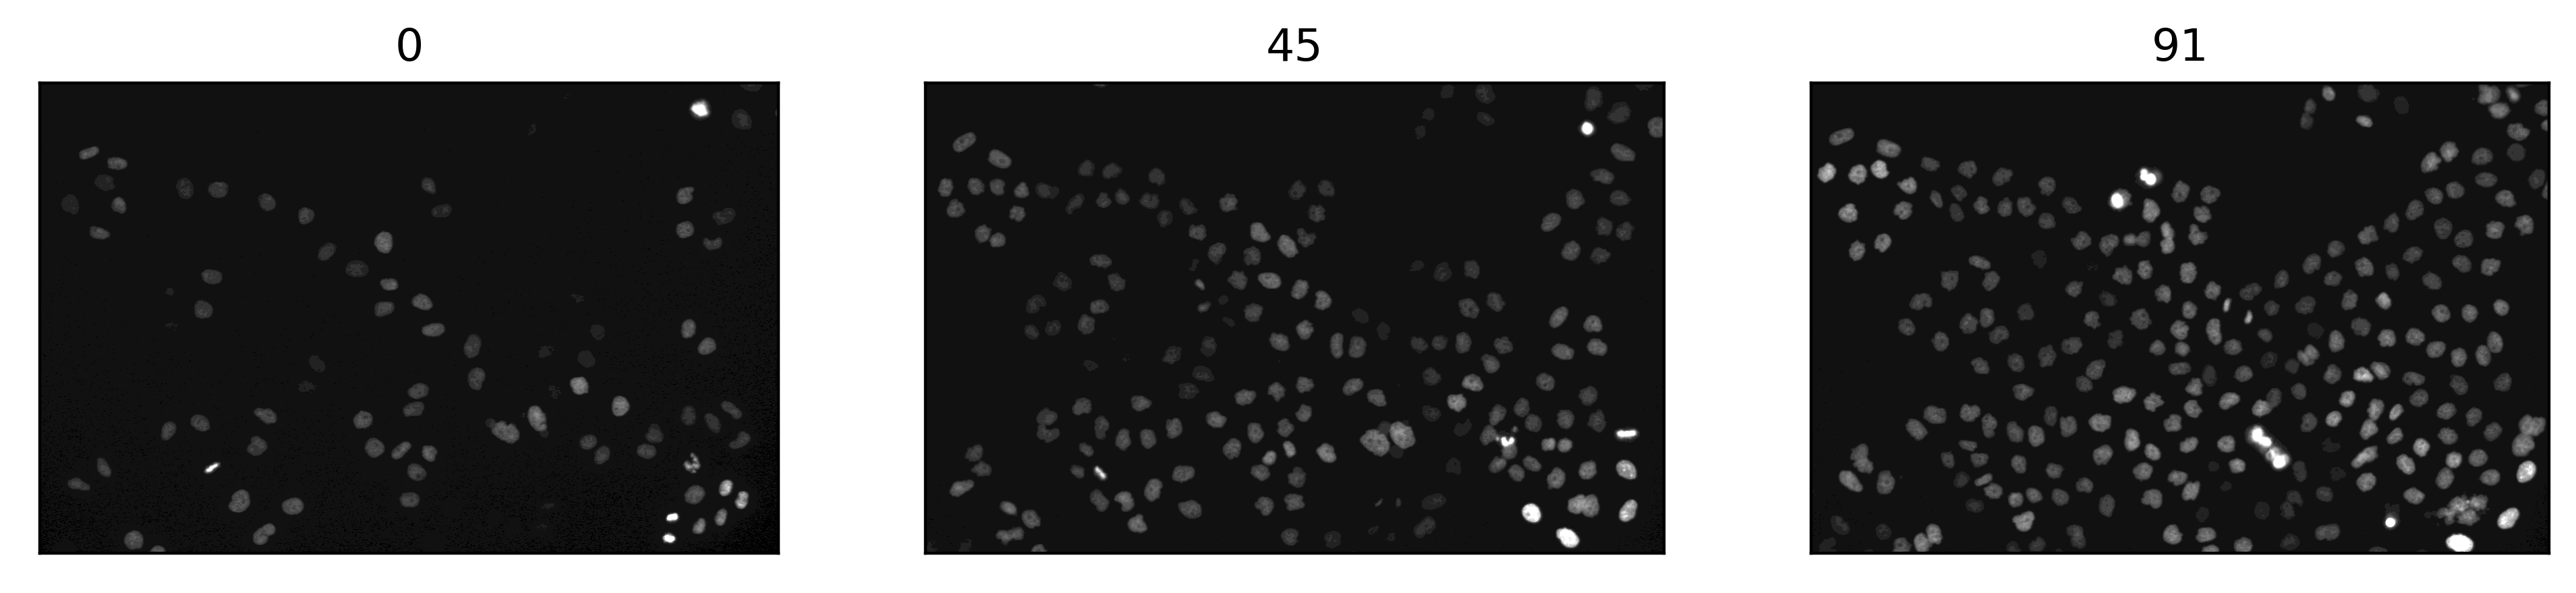

In [15]:
show_three_images(folder)

# 1-2 Use neural network to process images

In [16]:
model = NU_net(1, 16)
model.load_state_dict(torch.load('./model.dict', map_location=torch.device('cpu')))
model.eval()

NU_net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (to_00): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (to_10): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Batc

###### Use the model to process the images in Folder, it takes quite so long.. like 2-5 mins, depends on your computer

100%|███████████████████████████████████████████| 92/92 [04:24<00:00,  2.88s/it]


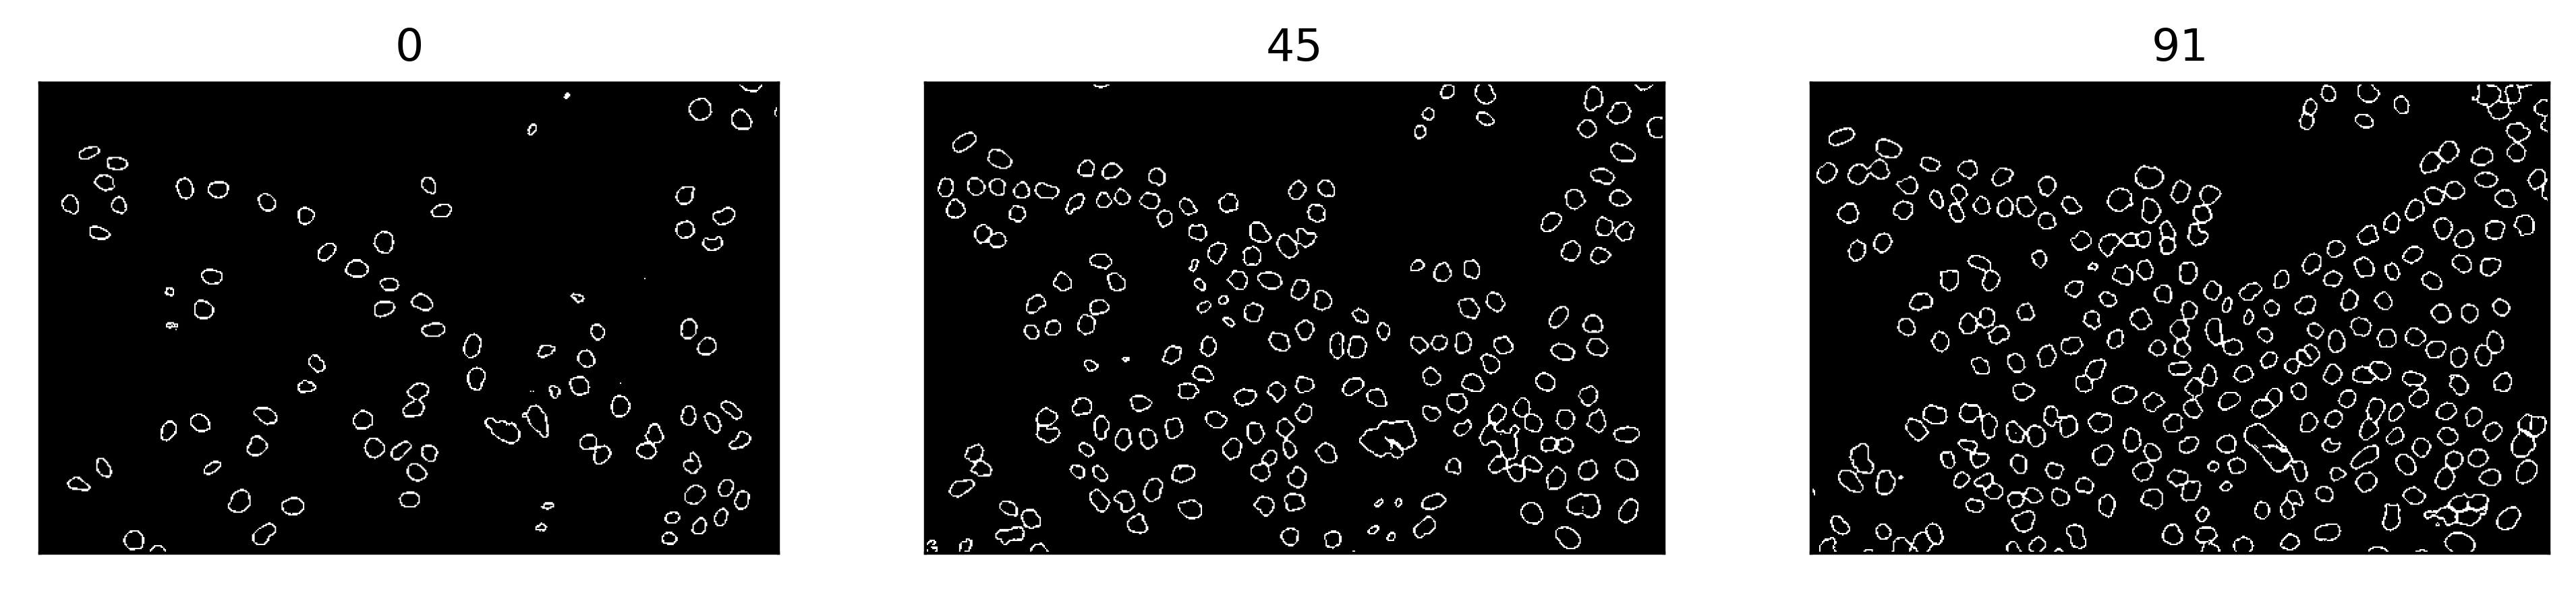

In [17]:
folder_outputs = folder_processing_with_model(folder, model)

###### You can comment this line if you think it takes too long. If you already close the window, an it is keep executing, you can just stop this cell and run others in orders.

In [18]:
show_images_in_animation_cv(folder_outputs)
cv2.destroyAllWindows()

##### This section will generate some processed images, you can comment this section if you want. 

In [19]:
d1 = image_processing_with_model_demo(folder[85], model, 0, frames=[], padding=0)
d2 = image_processing_with_model_demo(folder[85], model, 1, frames=[], padding=0)
d3 = image_processing_with_model_demo(folder[85], model, 0, frames=[])
d4 = image_processing_with_model_demo(folder[85], model, 1, frames=[])

###### Not add a padding. You can see some horizontal line and vertical line

In [20]:
compare_images_in_animation_cv([d1, d2], window_width=1900)

###### Add a padding, which could remove the horizontal and vertical lines.

In [21]:
compare_images_in_animation_cv([d3, d4], window_width=1900)

###### This section will takes 25 mins (depends on your computer's CPU). you can just skip this cell and next cell. Just run folder_outputs

100%|███████████████████████████████████████████| 92/92 [25:22<00:00, 16.55s/it]


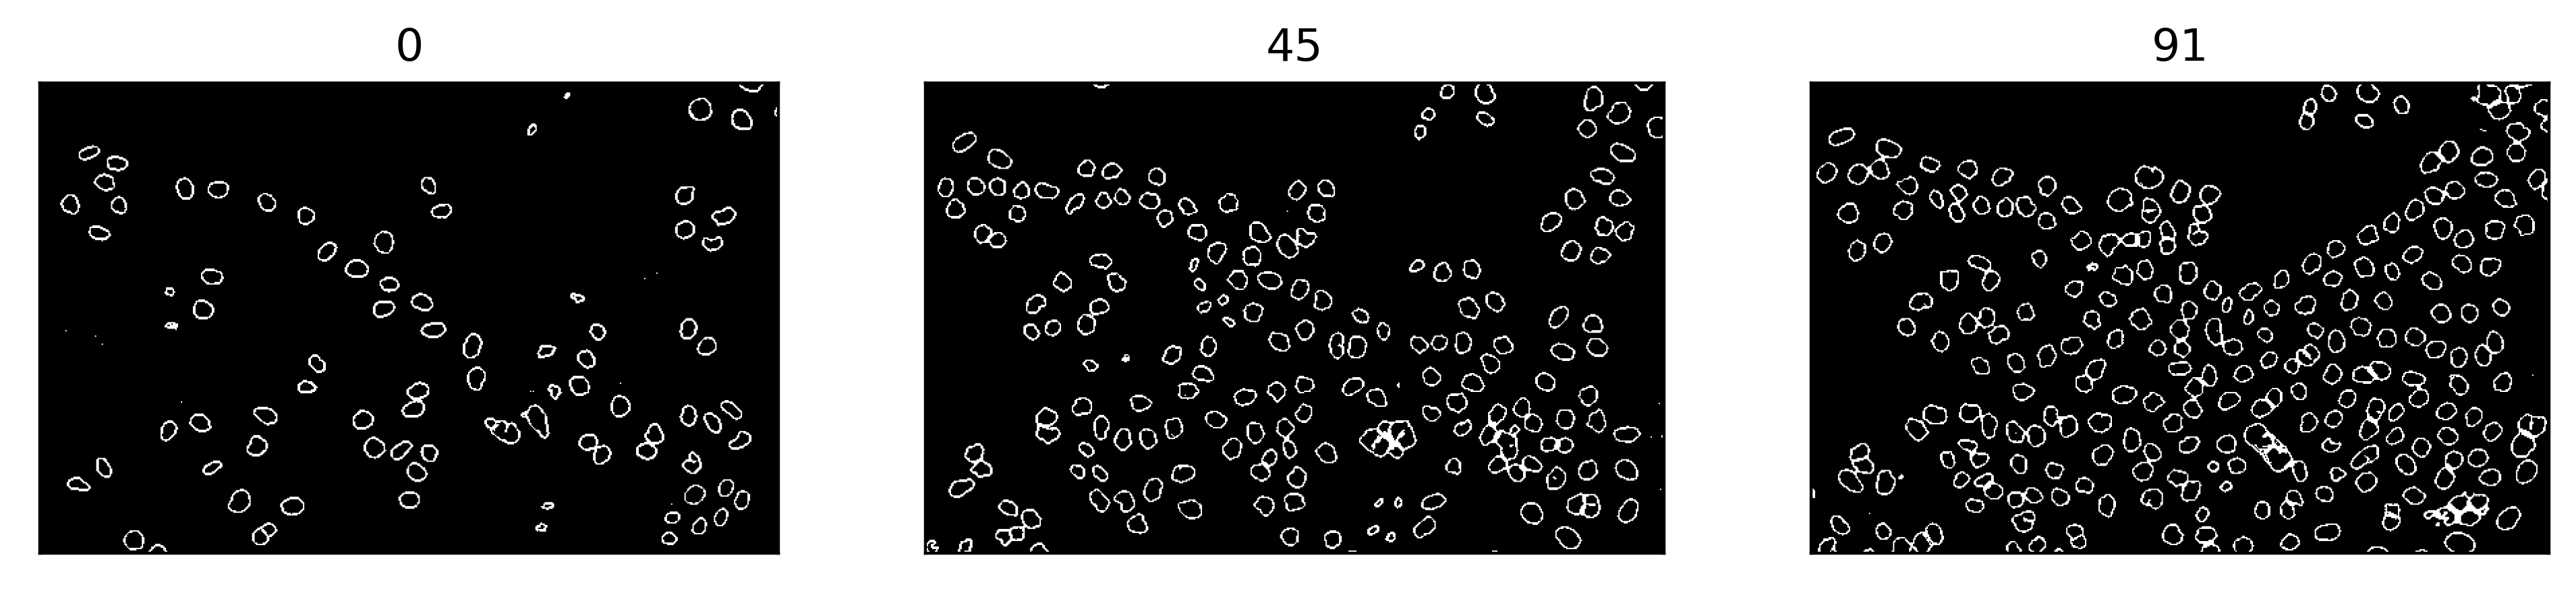

In [22]:
# This will take a long time, but we have saved the output of the model as pictures. 
# If you want to save time, you can skip this and the next line to load result image directly with no risk.
folder_outputs = folder_processing_with_model(folder, model, trans_list=[0, 1, 2, 3, 4, 5])

In [23]:
save_files(folder_outputs, f'./output_images/{process_folder}/02_model_outputs/')

In [24]:
# Load outputs directly
folder_outputs = open_files(f'./output_images/{process_folder}/02_model_outputs/', flags=cv2.IMREAD_GRAYSCALE)

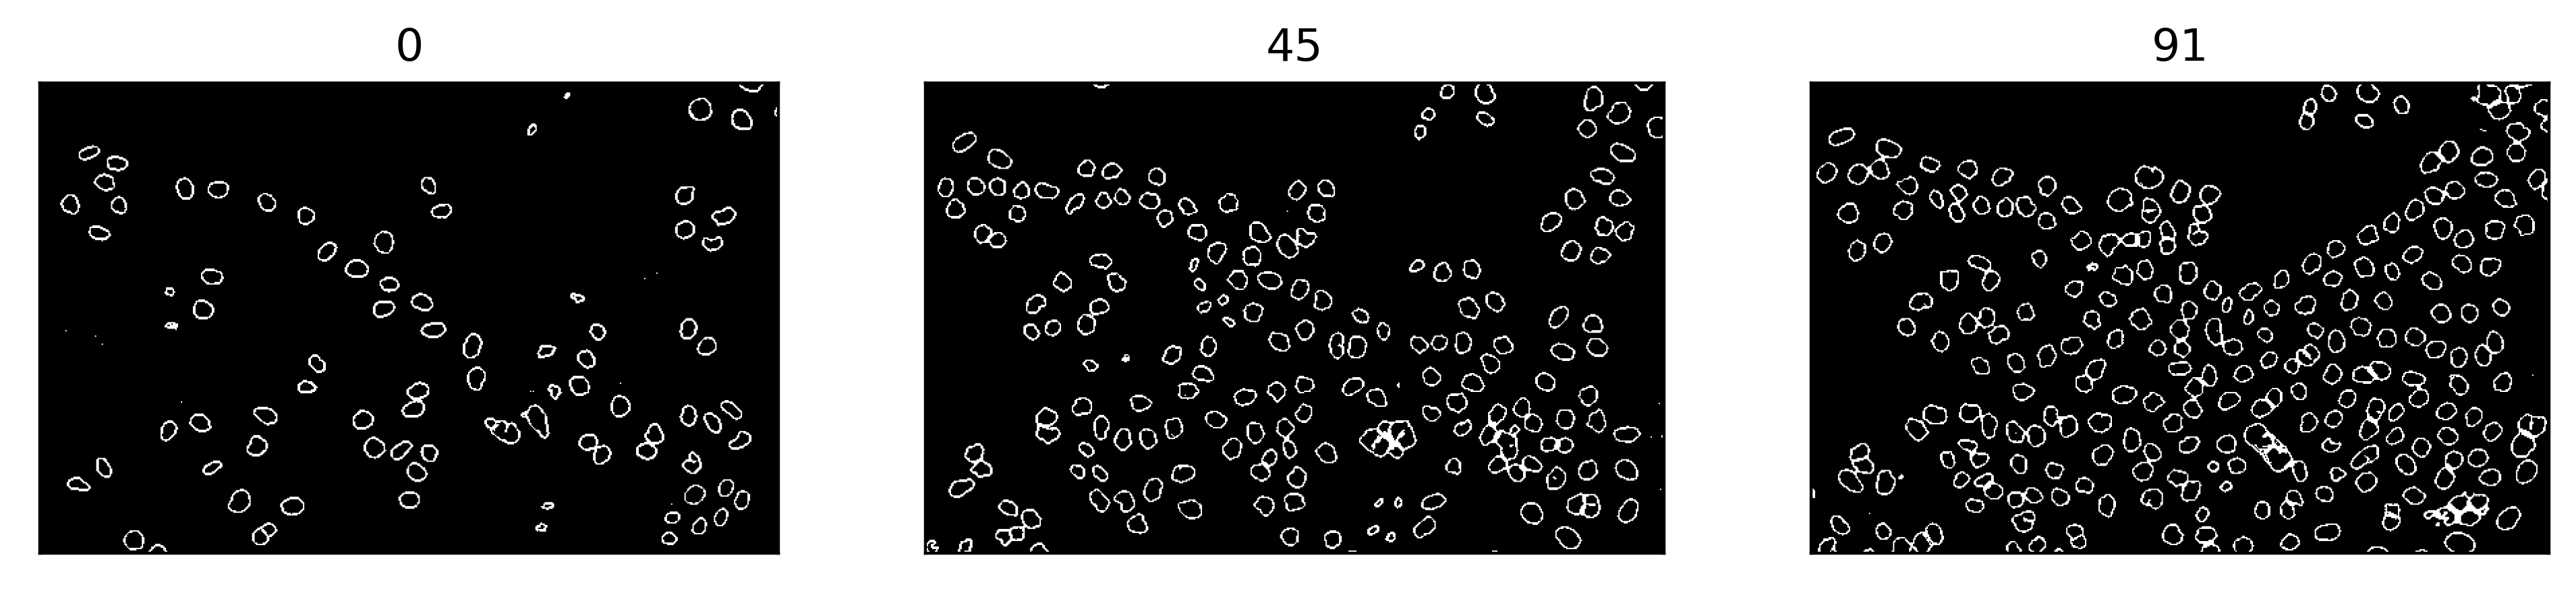

In [25]:
show_three_images(folder_outputs)

# 1-3 Post-processing

In [26]:
folder_outputs2 = fill_background(folder_outputs)

In [27]:
save_files(folder_outputs2, f'./output_images/{process_folder}/03_post_processed/')

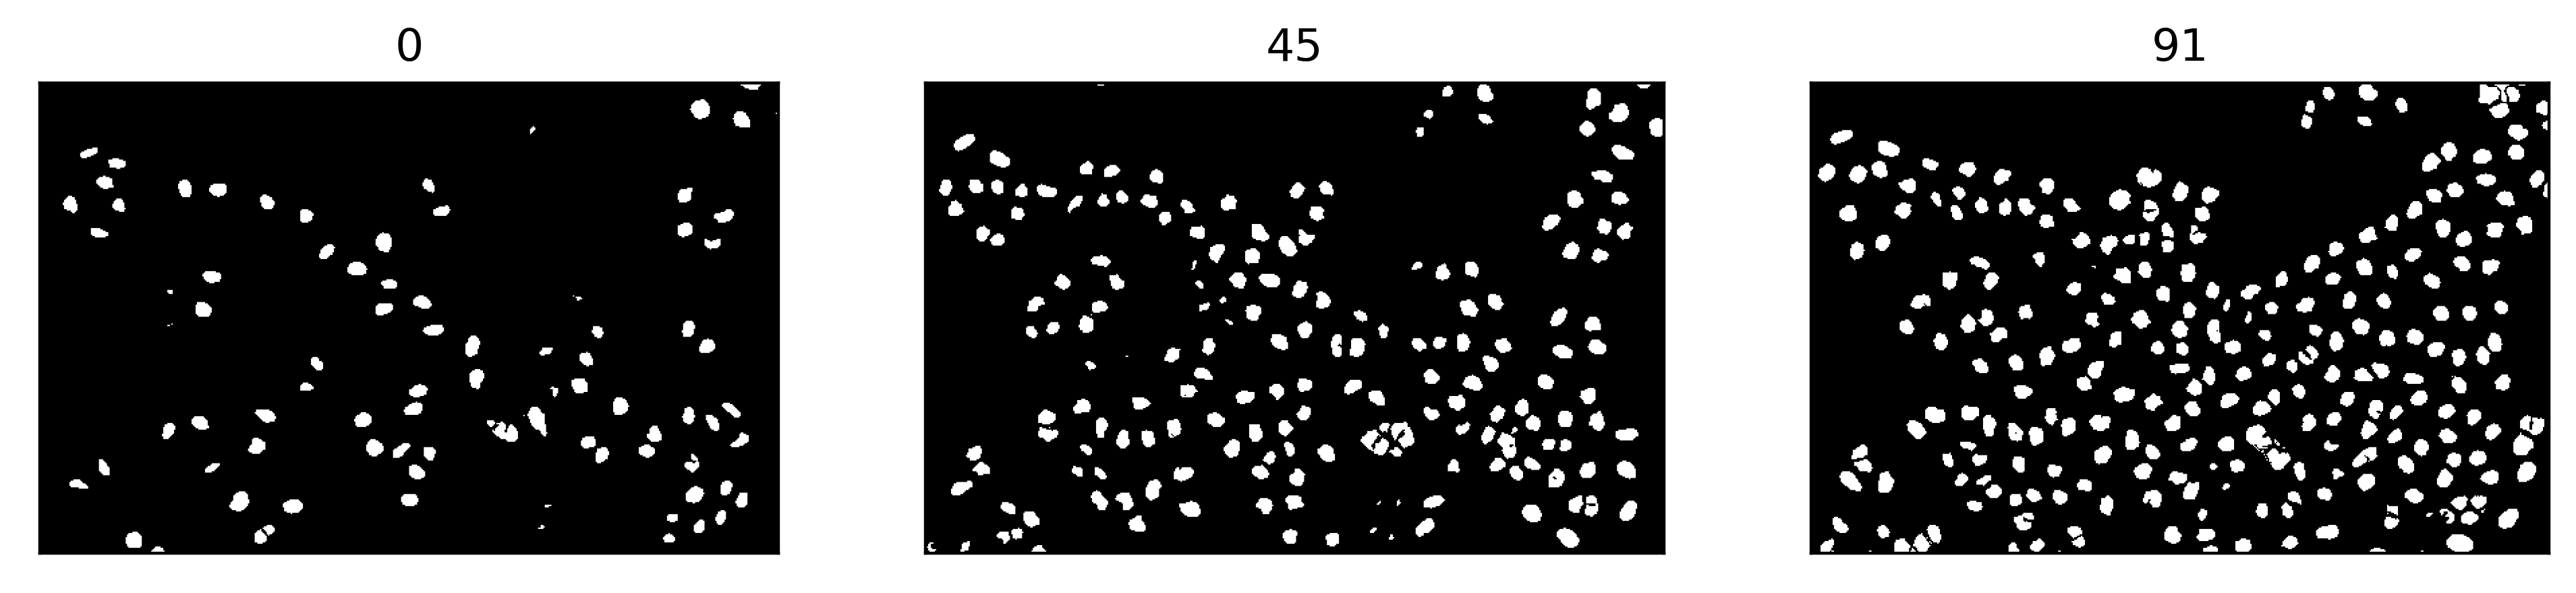

In [28]:
show_three_images(folder_outputs2)

# 1-4 Find contours and track ceils

In [29]:
all_contours = find_all_contours(folder_outputs2)
contour_ids, all_centroids, ceils_info, ceil_ids, division_records, average_displacement = ceil_indentify(all_contours)

100%|███████████████████████████████████████████| 92/92 [00:32<00:00,  2.86it/s]


# 1-5 Draw results

In [30]:
folder_results = draw_everything(all_contours, contour_ids, all_centroids, ceils_info, ceil_ids, division_records, average_displacement, folder_original)

In [31]:
save_files(folder_results, f'./output_images/{process_folder}/04_final_outputs/')

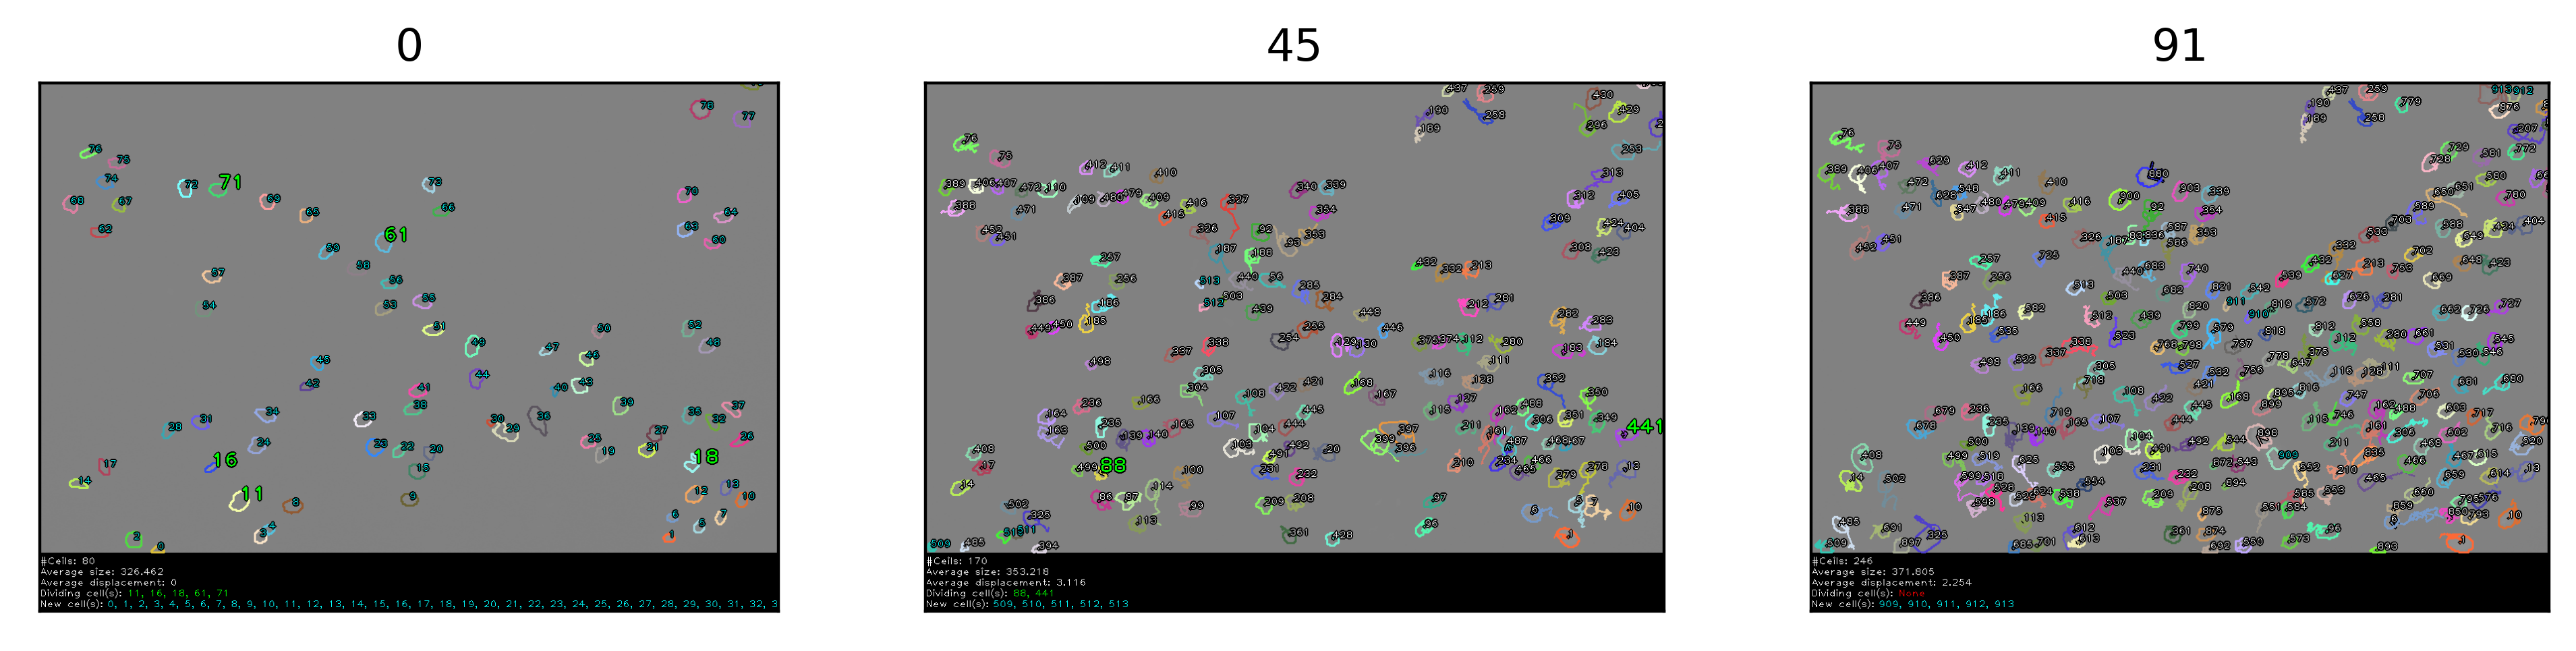

In [32]:
show_three_images(folder_results)

Folder 1 final output animation

In [33]:
show_images_in_animation_cv(folder_results)

In [34]:
folder_results_01 = open_files(f'./output_images/01/04_final_outputs/')
show_images_in_animation_cv(folder_results_01, interval=150)
cv2.destroyAllWindows()

In [35]:
folder_results_02 = open_files(f'./output_images/02/04_final_outputs/')
show_images_in_animation_cv(folder_results_02, interval=150)
cv2.destroyAllWindows()

In [36]:
folder_results_03 = open_files(f'./output_images/03/04_final_outputs/')
show_images_in_animation_cv(folder_results_03, interval=150)
cv2.destroyAllWindows()

In [37]:
folder_results_04 = open_files(f'./output_images/04/04_final_outputs/')
show_images_in_animation_cv(folder_results_04, interval=150)
cv2.destroyAllWindows()

In [38]:
# Draw paths in 3d
from mpl_toolkits.mplot3d import axes3d

def get_all_path_from_centroids(all_centroids, ceils_info):
    out = []
    paths = {}
    for i in range(len(all_centroids)):
        centroids = all_centroids[i]
        for k, v in centroids.items():
            if k not in paths.keys():
                paths[k] = {'x':[], 'y':[], 'z':[]}
            paths[k]['x'].append(v[1])
            paths[k]['y'].append(v[0])
            paths[k]['z'].append(i)

    fig = plt.figure(figsize=(6, 5), dpi=150)
    ax = fig.gca(projection='3d')
    ax.set_title('Ceils tracking')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Frame')
    ax.set_xlim3d(0, 1200)
    ax.set_ylim3d(0, 800)
    ax.set_zlim3d(0, 100)

    for i in range(len(all_centroids)):
        for k, v in paths.items():
            if i in v['z']:
                p = v['z'].index(i)
                color = np.flip(ceils_info['colors'][k])
                ax.plot(v['y'][0:p+1], v['x'][0:p+1], v['z'][0:p+1], c=np.array(color)/255)
            elif i > max(v['z']):
                color = ceils_info['colors'][k]
                ax.plot(v['y'], v['x'], v['z'], c=np.array(color)/255)

        fig.canvas.draw()
        width, height = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf = np.reshape(buf, (height, width, 4))
        buf = np.roll(buf, 3, 2)
        img = cv2.cvtColor(buf, cv2.COLOR_RGBA2BGR)
        out.append(img)
    return out

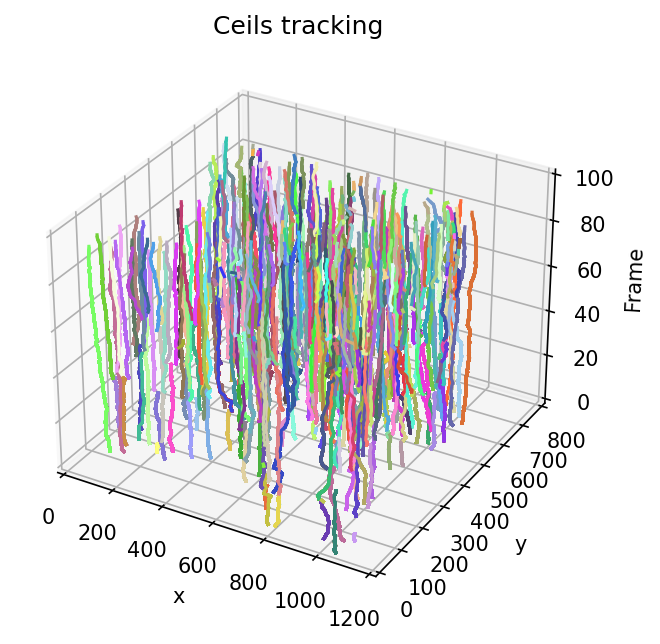

In [39]:
# Need some time to run this...
paths = get_all_path_from_centroids(all_centroids, ceils_info)

In [40]:
show_images_in_animation_cv(paths)

#### If you dont want to see the animation, you can just have a look for the output_images in the folder